Download Dataset from https://www.kaggle.com/datasets/fabiochiusano/medium-articles

In [1]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [3]:
import pandas as pd

df = pd.read_csv("medium_articles.csv")
df = df[["text"]]
df.head()

,text
0,Photo by Josh Riemer on Unsplash\n\nMerry Chri...
1,Your Brain On Coronavirus\n\nA guide to the cu...
2,Mind Your Nose\n\nHow smell training can chang...
3,Passionate about the synergy between science a...
4,"You’ve heard of him, haven’t you? Phineas Gage..."


In [4]:
n = int(0.9 * len(df))  # first 90% will be train, rest val
train_examples = df[:n]
val_examples = df[n:]

In [5]:
train_examples.head()

,text
0,Photo by Josh Riemer on Unsplash\n\nMerry Chri...
1,Your Brain On Coronavirus\n\nA guide to the cu...
2,Mind Your Nose\n\nHow smell training can chang...
3,Passionate about the synergy between science a...
4,"You’ve heard of him, haven’t you? Phineas Gage..."


In [6]:
train_examples = tf.data.Dataset.from_tensor_slices((train_examples))

In [7]:
val_examples.head()

,text
173131,The 3 things that led me to my success and can...
173132,We Live in Uncertain Times\n\nWe live in uncer...
173133,A majority of people aspire to be leaders and ...
173134,"In this article, we’ll share the top leadershi..."
173135,"I was recently catching up with a friend, and ..."


In [8]:
val_examples = tf.data.Dataset.from_tensor_slices((val_examples))

In [9]:
max_features = 5000  # Maximum vocab size
BATCH_SIZE = 32
MAX_TOKENS = 128
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
)
vectorize_layer.adapt(train_examples, batch_size=None)

In [10]:
vectorize_layer.vocabulary_size()

5000

In [11]:
vocabulary = vectorize_layer.get_vocabulary()

In [12]:
def prepare_batch(data):
    x = vectorize_layer(data)
    x = x[:, :(MAX_TOKENS)]
    X_train = x[:, :-1]
    y_train = x[:, 1:]
    return (X_train, y_train)

In [13]:
BUFFER_SIZE = 20000

In [14]:
def make_batches(ds):
    return (
        ds.shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [15]:
# Create training and validation set batches
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [16]:
for X_train, y_train in train_batches.take(1):
    break
print(X_train.shape)
print(y_train.shape)

(32, 127)
(32, 127)


In [17]:
print(X_train[10][:10])
print(y_train[10][:10])

tf.Tensor([ 414    1    1  705    2    1 1569  357    1 1970], shape=(10,), dtype=int64)
tf.Tensor([   1    1  705    2    1 1569  357    1 1970  159], shape=(10,), dtype=int64)


In [18]:
for x_batch, y_batch in train_batches.take(1):
    break

In [19]:
x_batch.shape

TensorShape([32, 127])

In [20]:
y_batch.shape

TensorShape([32, 127])

The embedding and positional encoding layer

In [71]:
def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

    angle_rates = 1 / (10000**depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


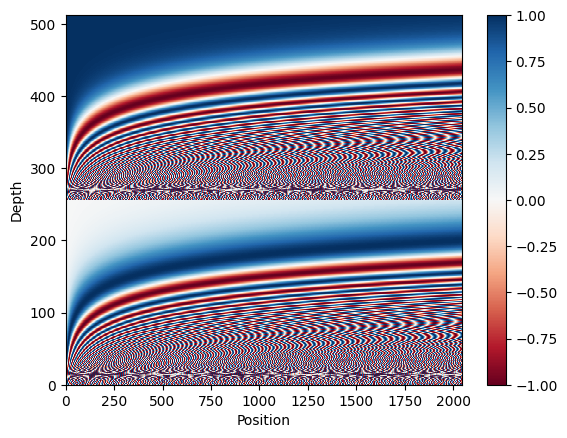

In [72]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap="RdBu")
plt.ylabel("Depth")
plt.xlabel("Position")
plt.colorbar()
plt.show()

(0.0, 1.0)

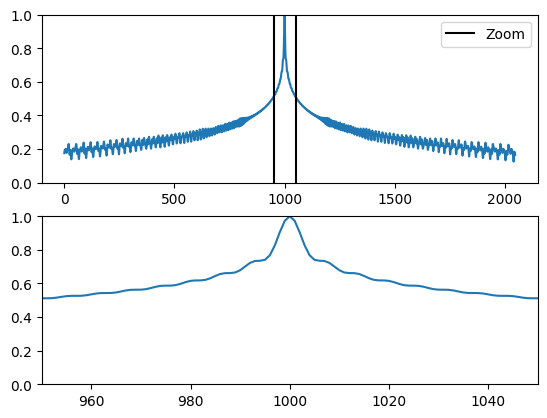

In [73]:
pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum("pd,d -> p", pos_encoding, p)
plt.subplot(2, 1, 1)
plt.plot(dots)
plt.ylim([0, 1])
plt.plot(
    [950, 950, float("nan"), 1050, 1050],
    [0, 1, float("nan"), 0, 1],
    color="k",
    label="Zoom",
)
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0, 1])

In [74]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self,vocab_size,d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [75]:
x_batch.shape

TensorShape([32, 127])

In [76]:
x_batch_emb = PositionalEmbedding(vocab_size=max_features, d_model=512)
x_batch_emb = x_batch_emb(x_batch)

The base attention layer

In [78]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

The causal self attention layer

In [79]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output, attn_scores = self.mha(
            query=x, value=x, key=x, return_attention_scores=True, use_causal_mask=True
        )
        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [81]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(x_batch_emb.shape)
print(sample_csa(x_batch_emb).shape)

(32, 127, 512)
(32, 127, 512)


The feed forward network

In [82]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(dff, activation="relu"),
                tf.keras.layers.Dense(d_model),
                tf.keras.layers.Dropout(dropout_rate),
            ]
        )
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

The decoder layer

In [83]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads, key_dim=d_model, dropout=dropout_rate
        )

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.causal_self_attention(x=x)
        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.causal_self_attention.last_attn_scores
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

The decoder

In [84]:
class Decoder(tf.keras.layers.Layer):
    def __init__(
        self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1
    ):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(
                d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate
            )
            for _ in range(num_layers)
        ]

        self.last_attn_scores = None

    def call(self, x):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

Test the decoder:

In [85]:
# Instantiate the decoder.
sample_decoder = Decoder(
    num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=8000
)

output = sample_decoder(x=x_batch)

# Print the shapes.
print(x_batch.shape)
print(x_batch_emb.shape)
print(output.shape)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'causal_self_attention_2' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'decoder_layer' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(32, 127)
(32, 127, 512)
(32, 127, 512)


In [86]:
print(sample_decoder(x_batch))

tf.Tensor(
[[[-5.97456276e-01 -1.63438809e+00  6.25948131e-01 ...  1.07048064e-01
    9.09924984e-01  1.16076696e+00]
  [-1.64289844e+00  8.67006123e-01 -1.44909966e+00 ...  2.39588594e+00
    2.49300614e-01  1.90751404e-01]
  [-4.39000309e-01 -8.95184338e-01 -8.64103913e-01 ...  1.63059306e+00
   -1.33177936e-02  1.73146486e-01]
  ...
  [-1.58375382e+00 -1.77901971e+00 -1.20412841e-01 ... -4.11596090e-01
    5.00476241e-01  1.79214144e+00]
  [-1.58546138e+00 -1.40660095e+00  8.99924517e-01 ...  1.40230322e+00
    4.44118857e-01  1.20790982e+00]
  [-3.59139711e-01  1.09691262e-01 -9.26457882e-01 ...  2.10278320e+00
    1.64551392e-01  1.20132327e+00]]

 [[-1.06382787e+00 -6.23639405e-01  4.13435459e-01 ...  1.21323240e+00
   -3.02746985e-02 -4.31357950e-01]
  [ 5.98996997e-01 -2.79073626e-01 -7.22357392e-01 ...  2.11426997e+00
   -4.70901877e-02  4.35577750e-01]
  [ 1.51500976e+00 -1.09731197e+00 -1.55058309e-01 ...  1.25338399e+00
    6.95869267e-01  2.25329235e-01]
  ...
  [-2.740622

The GPT Transformer

In [87]:
class Transformer(tf.keras.Model):
    def __init__(
        self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1
    ):
        super().__init__()

        self.decoder = Decoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            vocab_size=input_vocab_size,
            dropout_rate=dropout_rate,
        )

        self.final_layer = tf.keras.layers.Dense(input_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        x = inputs

        x = self.decoder(x)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

Hyperparameters

The base model described in the original Transformer paper used num_layers=6, d_model=512, and dff=2048.

In [88]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [89]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=max_features,
    dropout_rate=dropout_rate,
)

In [90]:
output = transformer(x_batch)

print(x_batch.shape)
print(output.shape)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'decoder_layer_4' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(32, 127)
(32, 127, 5000)


In [91]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(32, 8, 127, 127)


In [92]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_1 (Decoder)             │ ?                      │     3,278,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (32, 127, 5000)        │       645,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,923,848 (14.97 MB)

 Trainable params: 3,923,848 (14.97 MB)

 Non-trainable params: 0 (0.00 B)

Training

In [93]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [94]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

Text(0.5, 0, 'Train Step')

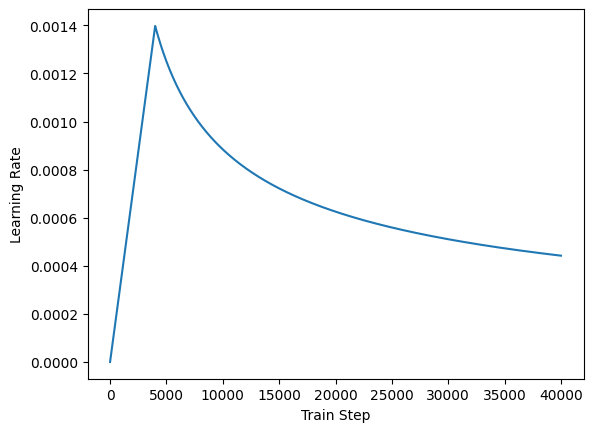

In [95]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

Set up the loss and metrics

In [96]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

Train the Model

In [97]:
transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

In [98]:
history = transformer.fit(train_batches, epochs=10, validation_data=val_batches)

Epoch 1/10


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'decoder_layer_4' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5411/5411 ━━━━━━━━━━━━━━━━━━━━ 1014s 186ms/step - loss: 5.7137 - masked_accuracy: 0.1725 - val_loss: 4.5084 - val_masked_accuracy: 0.2307
Epoch 2/10
5411/5411 ━━━━━━━━━━━━━━━━━━━━ 1026s 190ms/step - loss: 4.4190 - masked_accuracy: 0.2324 - val_loss: 4.3198 - val_masked_accuracy: 0.2454
Epoch 3/10
5411/5411 ━━━━━━━━━━━━━━━━━━━━ 1027s 190ms/step - loss: 4.2664 - masked_accuracy: 0.2444 - val_loss: 4.2572 - val_masked_accuracy: 0.2508
Epoch 4/10
5411/5411 ━━━━━━━━━━━━━━━━━━━━ 1005s 186ms/step - loss: 4.1959 - masked_accuracy: 0.2507 - val_loss: 4.2191 - val_masked_accuracy: 0.2543
Epoch 5/10
5411/5411 ━━━━━━━━━━━━━━━━━━━━ 1002s 185ms/step - loss: 4.1533 - masked_accuracy: 0.2548 - val_loss: 4.1989 - val_masked_accuracy: 0.2563
Epoch 6/10
5411/5411 ━━━━━━━━━━━━━━━━━━━━ 1009s 186ms/step - loss: 4.1238 - masked_accuracy: 0.2575 - val_loss: 4.1859 - val_masked_accuracy: 0.2577
Epoch 7/10
5411/5411 ━━━━━━━━━━━━━━━━━━━━ 1004s 186ms/step - loss: 4.1005 - masked_accuracy: 0.2598 - val_loss: 4.176

<Axes: >

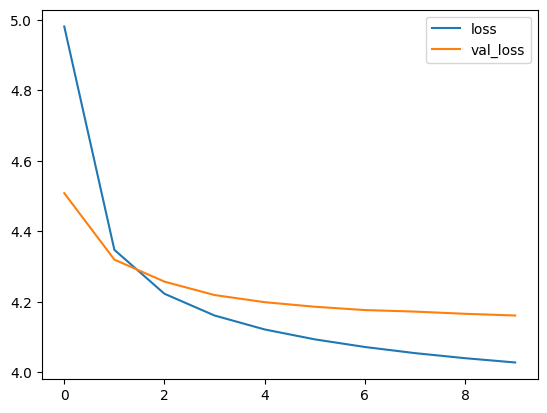

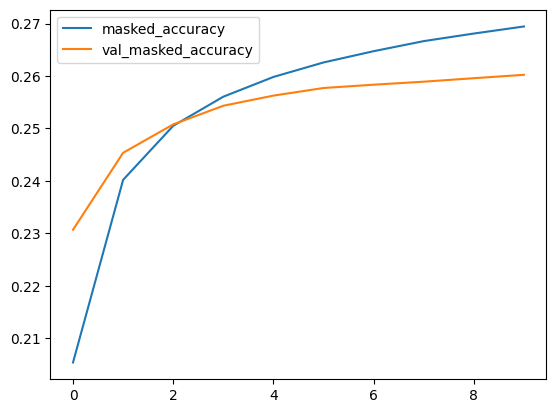

In [99]:
metrics_df = pd.DataFrame(history.history)
metrics_df[["loss", "val_loss"]].plot()
metrics_df[["masked_accuracy", "val_masked_accuracy"]].plot()

Run inference

In [107]:
sentence = "Python"
x = vectorize_layer(sentence)

In [108]:
x

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([663])>

In [109]:
x = tf.expand_dims(x, axis=0)

In [111]:
prediction = transformer(x)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'decoder_layer_4' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask informat

In [112]:
prediction

<tf.Tensor: shape=(1, 1, 5000), dtype=float32, numpy=
array([[[-13.577198 ,   5.1689143,   1.6549237, ...,  -7.669855 ,
          -2.7833557,  -4.539361 ]]], dtype=float32)>

In [114]:
# Shape `(batch_size, 1, vocab_size)`
predictions = prediction[:, -1:, :]  # Select the last token from the `seq_len` dimension.

In [115]:
predictions

<tf.Tensor: shape=(1, 1, 5000), dtype=float32, numpy=
array([[[-13.577198 ,   5.1689143,   1.6549237, ...,  -7.669855 ,
          -2.7833557,  -4.539361 ]]], dtype=float32)>

In [117]:
predictions[0]

<tf.Tensor: shape=(1, 5000), dtype=float32, numpy=
array([[-13.577198 ,   5.1689143,   1.6549237, ...,  -7.669855 ,
         -2.7833557,  -4.539361 ]], dtype=float32)>

In [118]:
predicted_id = tf.argmax(predictions, axis=-1)

In [119]:
predicted_id

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[8]])>

In [124]:
tf.concat(x,np.array(predicted_id[0])[0])

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[663]])>

In [ ]:
tf.concat(x, np.array(predicted_id[0])[0])

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[663]])>

In [128]:
tf.experimental.numpy.append(x, predicted_id[0], axis=None)

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([663,   8])>

In [129]:
x_concat = tf.experimental.numpy.append(x, predicted_id[0], axis=None)

In [133]:
x_concat_xpand = tf.expand_dims(x_concat, axis=0)

In [134]:
x_concat_xpand

<tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[663,   8]])>

In [135]:
transformer(x_concat_xpand)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'decoder_layer_4' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


<tf.Tensor: shape=(1, 2, 5000), dtype=float32, numpy=
array([[[-13.577219 ,   5.168916 ,   1.6549225, ...,  -7.6698666,
          -2.783367 ,  -4.5393715],
        [-19.747147 ,   3.4920893,   5.2994747, ...,  -9.619615 ,
          -6.8138037,  -7.5593176]]], dtype=float32)>

In [136]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup
id_to_word = tf.keras.layers.StringLookup(
    vocabulary=vocabulary, mask_token="", oov_token="[UNK]", invert=True
)

In [138]:
id_to_word(predicted_id)

<tf.Tensor: shape=(1, 1), dtype=string, numpy=array([[b'is']], dtype=object)>

In [139]:
id_to_word(predicted_id)[0]

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'is'], dtype=object)>

In [142]:
scores = tf.nn.softmax(predictions[0])
scores = scores.numpy()
scores[0]

array([8.8340640e-10, 1.2231892e-01, 3.6423940e-03, ..., 3.2485300e-07,
       4.3039443e-05, 7.4343548e-06], dtype=float32)

In [143]:
scores_df = pd.DataFrame(data=scores[0], columns=["score"])
scores_df.reset_index(inplace=True)
scores_df.head()

,index,score
0,0,8.834064e-10
1,1,1.223189e-01
2,2,3.642394e-03
3,3,1.866038e-02
4,4,5.923464e-02


In [144]:
words = pd.DataFrame(data=vocabulary, columns=["word"])
words.reset_index(inplace=True)
words.head()

,index,word
0,0,
1,1,[UNK]
2,2,the
3,3,to
4,4,and


In [145]:
final_scores = scores_df.merge(words)

In [146]:
final_scores.head()

,index,score,word
0,0,8.834064e-10,
1,1,1.223189e-01,[UNK]
2,2,3.642394e-03,the
3,3,1.866038e-02,to
4,4,5.923464e-02,and


In [147]:
final_scores = final_scores.sort_values(by=["score"], ascending=False)

In [148]:
final_scores

,index,score,word
8,8,1.797556e-01,is
1,1,1.223189e-01,[UNK]
982,982,6.627733e-02,programming
4,4,5.923464e-02,and
663,663,2.843886e-02,python
...,...,...,...
3741,3741,4.418295e-09,invite
3470,3470,3.703628e-09,broadcast
4986,4986,2.201571e-09,realise
0,0,8.834064e-10,


In [149]:
final_scores_20 = final_scores.head(20)

In [150]:
final_scores_20

,index,score,word
8,8,0.179756,is
1,1,0.122319,[UNK]
982,982,0.066277,programming
4,4,0.059235,and
663,663,0.028439,python
11,11,0.027890,for
3,3,0.018660,to
1212,1212,0.017189,vs
47,47,0.016056,has
7,7,0.015559,in


<Axes: xlabel='word', ylabel='score'>

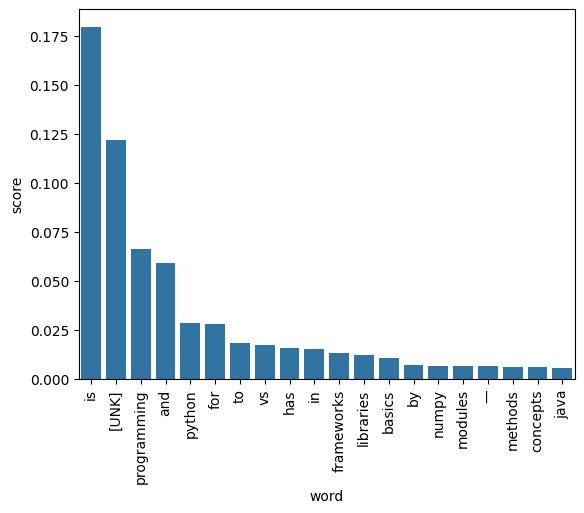

In [151]:
plt.xticks(rotation=90)
sns.barplot(data=final_scores_20, x="word", y="score")

In [ ]:
class Generator(tf.Module):
    def __init__(
        self,
        tokenizer,
        vocabulary,
        transformer,
        max_new_tokens,
        temperature=0.0,
    ):
        self.tokenizer = tokenizer
        self.transformer = transformer
        self.vocabulary = vocabulary
        self.max_new_tokens = max_new_tokens
        self.temperature = temperature

    def __call__(self, sentence, max_length=MAX_TOKENS):
        sentence = self.tokenizer(sentence)
        sentence = tf.expand_dims(sentence, axis=0)
        encoder_input = sentence
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)

        print(f"Generating {self.max_new_tokens} tokens")
        for i in tf.range(self.max_new_tokens):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer(encoder_input, training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
            if self.temperature == 0.0:
                # greedy sampling, output always the same
                predicted_id = tf.argmax(predictions, axis=-1)
            else:
                predictions = predictions / self.temperature
                predicted_id = tf.random.categorical(predictions[0], num_samples=1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i + 1, predicted_id[0])
            encoder_input = tf.experimental.numpy.append(encoder_input, predicted_id[0])
            encoder_input = tf.expand_dims(encoder_input, axis=0)

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        id_to_word = tf.keras.layers.StringLookup(
            vocabulary=self.vocabulary, mask_token="", oov_token="[UNK]", invert=True
        )

        print(f"Using temperature of {self.temperature}")
        text = id_to_word(output)
        tokens = output

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer(output[:, :-1], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

In [153]:
max_new_tokens = 50
temperature = 0.92
generator = Generator(
    vectorize_layer, vocabulary, transformer, max_new_tokens, temperature, 
)

In [154]:
def print_generation(sentence, generated_text):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Generation":15s}: {generated_text}')

In [155]:
sentence = "In this article, we’ll share the top leadership"
generated_text, generated_tokens, attention_weights = generator(sentence)

Generating 50 tokens


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'decoder_layer_4' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Using temperature of 0.92


In [156]:
generated_tokens

<tf.Tensor: shape=(1, 51), dtype=int64, numpy=
array([[   0,  594,    9,   12, 1222,  900,    2,  280,  255,    1,   30,
         240,    8,    1,    1,    4,   12,  184,    6,  188, 1283,  200,
           2,  616,   12, 1073,    2,  365,    4,   12, 1821,    3, 1122,
          60, 1552,    5,    6,  223,  800,   12,   25,  116,  951,   17,
         120,   17,   30, 1199,   15,    1,   12]])>

In [157]:
print_generation(sentence, generated_text)

Input:         : In this article, we’ll share the top leadership
Generation     : [[b'' b'skills' b'that' b'i' b'cover' b'throughout' b'the' b'job'
  b'market' b'[UNK]' b'my' b'name' b'is' b'[UNK]' b'[UNK]' b'and' b'i'
  b'am' b'a' b'great' b'startup' b'during' b'the' b'pandemic' b'i'
  b'wrote' b'the' b'book' b'and' b'i' b'seek' b'to' b'explore' b'some'
  b'aspects' b'of' b'a' b'design' b'journey' b'i' b'was' b'very'
  b'review' b'as' b'well' b'as' b'my' b'background' b'on' b'[UNK]' b'i']]


In [162]:
sentence = 'In this post, I want to share how to get started, who should write on Medium'
generated_text, generated_tokens, attention_weights = generator(sentence)

Generating 50 tokens


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'decoder_layer_4' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Using temperature of 0.92


In [163]:
generated_tokens

<tf.Tensor: shape=(1, 51), dtype=int64, numpy=
array([[   0,   41,   35,   12,  326,    1,  149,    1,    1,    1,    1,
        3477,    2,   86,   50,   35, 1018,    7,    2, 3501,  895,    8,
           9,   13,    8,   50,    3,   70,   60,  115,    1,   20, 1268,
          11,    2,  895,  108,   86,    2, 3136,    8,   37,    2,    1,
        4470,  484,  749,   48,   34,   49,    4]])>

In [164]:
generated_text

<tf.Tensor: shape=(1, 51), dtype=string, numpy=
array([[b'', b'what', b'if', b'i', b'write', b'[UNK]', b'really',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'scheme', b'the',
        b'first', b'time', b'if', b'interested', b'in', b'the',
        b'wordpress', b'site', b'is', b'that', b'it', b'is', b'time',
        b'to', b'get', b'some', b'good', b'[UNK]', b'be', b'nice',
        b'for', b'the', b'site', b'here', b'first', b'the', b'plugin',
        b'is', b'all', b'the', b'[UNK]', b'plugins', b'probably',
        b'developers', b'like', b'they', b'do', b'and']], dtype=object)>

In [169]:
sentence = "Python"
generated_text, generated_tokens, attention_weights = generator(sentence)
print_generation(sentence, generated_text)

Generating 50 tokens


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Using temperature of 0.92
Input:         : Python
Generation     : [[b'' b'and' b'it' b'makes' b'a' b'lot' b'of' b'life' b'as' b'we' b'know'
  b'it' b'remains' b'red' b'just' b'because' b'of' b'[UNK]' b'in' b'the'
  b'data' b'science' b'material' b'[UNK]' b'[UNK]' b'the' b'first'
  b'step' b'in' b'studying' b'python' b'is' b'the' b'[UNK]' b'stone'
  b'python' b'as' b'you' b'can' b'just' b'download' b'that' b'by'
  b'[UNK]' b'the' b'data' b'looking' b'what' b'is' b'available' b'[UNK]']]


In [170]:
def plot_attention_head(in_tokens, generated_tokens, attention):
    generated_tokens = generated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(generated_tokens)))

    labels = [label for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)

    labels = [label for label in generated_tokens.numpy()]
    ax.set_yticklabels(labels)

In [171]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([50, 50])

In [172]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = vectorize_layer(in_tokens)
in_tokens

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[663]])>

In [173]:
def plot_attention_weights(sentence, generated_tokens, attention_heads):
    in_tokens = vectorize_layer([sentence])

    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h + 1)

        plot_attention_head(in_tokens, generated_tokens, head)

        ax.set_xlabel(f"Head {h+1}")

    plt.tight_layout()
    plt.show()

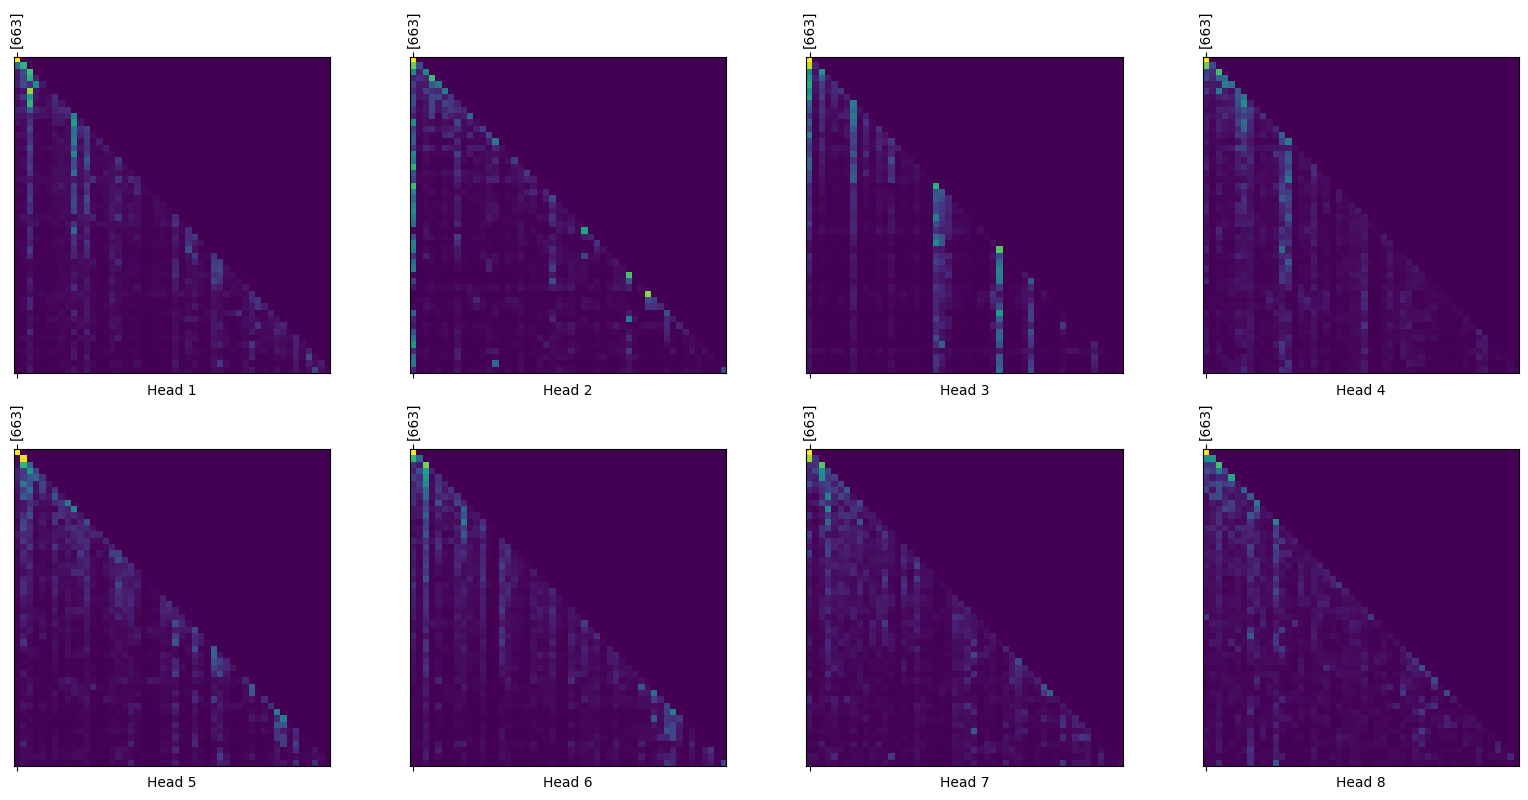

<Figure size 640x480 with 0 Axes>

In [174]:
plot_attention_weights(sentence, generated_tokens, attention_weights[0])
plt.tight_layout()

In [175]:
sentence = "Python is a well know programming language"

generated_text, generated_tokens, attention_weights = generator(sentence)
print_generation(sentence, generated_text)

Generating 50 tokens


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'decoder_layer_4' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Using temperature of 0.92
Input:         : Python is a well know programming language
Generation     : [[b'' b'it\xe2\x80\x99s' b'not' b'only' b'for' b'the' b'other'
  b'programming' b'language' b'nevertheless' b'python' b'[UNK]'
  b'what\xe2\x80\x99s' b'the' b'advantage' b'of' b'[UNK]' b'many' b'os'
  b'programming' b'languages' b'make' b'it' b'easy' b'to' b'install'
  b'python' b'is' b'a' b'great' b'interactive' b'[UNK]' b'editor' b'of'
  b'the' b'python' b'project' b'one' b'may' b'make' b'it' b'easy' b'for'
  b'you' b'to' b'do' b'it' b'with' b'python' b'you' b'can']]


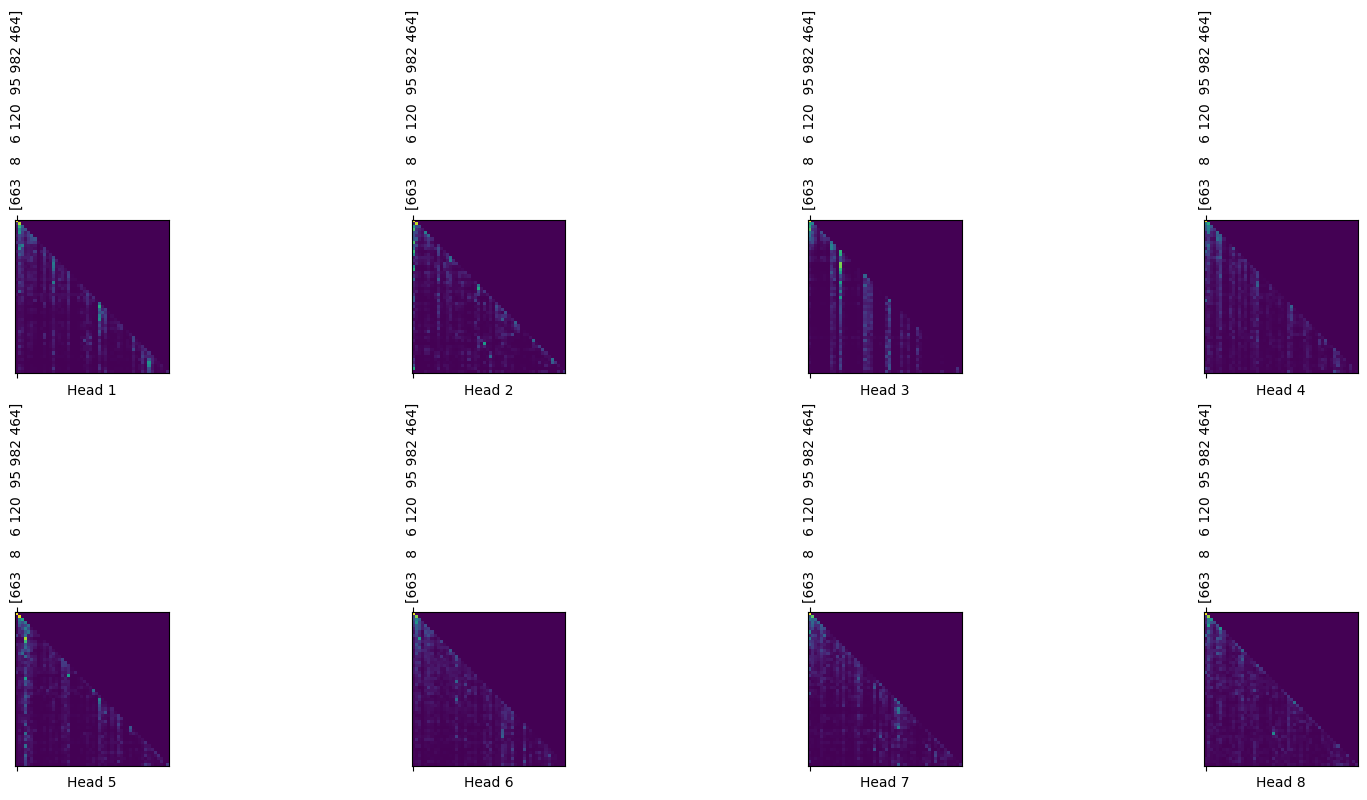

<Figure size 640x480 with 0 Axes>

In [176]:
plot_attention_weights(sentence, generated_tokens, attention_weights[0])
plt.tight_layout()